<a href="https://colab.research.google.com/github/kevinhc2/GDP_Growth_Predictor/blob/main/GDP_Growth_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Importing required modules

In [11]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading data in

In [12]:
df = pd.read_csv("/content/drive/My Drive/Quarter 1 ML Project/Unprocessed Data/WDI_2012-2021_data.csv")

Dropping instances with missing value for class attribute

In [13]:
droppable = []
for i in range(len(df.index)):
  if pd.isnull(df.iloc[i]["GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]"]):
    droppable.append(i)
df = df.drop(droppable)

Dropping irrelevant attributes like country name and code

In [14]:
useless = ["Time", "Time Code", "Country Name", "Country Code"]
df = df.drop(useless, axis=1)

Remove derivable attributes

In [15]:
#'GNI, Atlas method (current US$) [NY.GNP.ATLS.CD]',
# 'GNI, PPP (current international $) [NY.GNP.MKTP.PP.CD]'
# 'Population density (people per sq. km of land area) [EN.POP.DNST]'
derivable = ['GNI, Atlas method (current US$) [NY.GNP.ATLS.CD]', 'GNI, PPP (current international $) [NY.GNP.MKTP.PP.CD]', 'Population density (people per sq. km of land area) [EN.POP.DNST]']
df.drop(derivable, axis=1)

,"Adolescent fertility rate (births per 1,000 women ages 15-19) [SP.ADO.TFRT]","Agriculture, forestry, and fishing, value added (% of GDP) [NV.AGR.TOTL.ZS]","Annual freshwater withdrawals, total (% of internal resources) [ER.H2O.FWTL.ZS]",Births attended by skilled health staff (% of total) [SH.STA.BRTC.ZS],CO2 emissions (metric tons per capita) [EN.ATM.CO2E.PC],"Contraceptive prevalence, any method (% of married women ages 15-49) [SP.DYN.CONU.ZS]",Domestic credit provided by financial sector (% of GDP) [FS.AST.DOMS.GD.ZS],Electric power consumption (kWh per capita) [EG.USE.ELEC.KH.PC],Energy use (kg of oil equivalent per capita) [EG.USE.PCAP.KG.OE],Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS],...,"School enrollment, primary (% gross) [SE.PRM.ENRR]","School enrollment, primary and secondary (gross), gender parity index (GPI) [SE.ENR.PRSC.FM.ZS]","School enrollment, secondary (% gross) [SE.SEC.ENRR]",Statistical Capacity Score (Overall Average) (scale 0 - 100) [IQ.SCI.OVRL],Surface area (sq. km) [AG.SRF.TOTL.K2],Tax revenue (% of GDP) [GC.TAX.TOTL.GD.ZS],Terrestrial and marine protected areas (% of total territorial area) [ER.PTD.TOTL.ZS],Time required to start a business (days) [IC.REG.DURS],"Total debt service (% of exports of goods, services and primary income) [DT.TDS.DECT.EX.ZS]",Urban population growth (annual %) [SP.URB.GROW]
0,100.797,24.390874,43.015907,39.9,0.259295,NaN,NaN,NaN,NaN,NaN,...,103.492394,0.66925,53.618050,50.000000,652860.0,7.707801,NaN,9.5,0.598264,4.288951
1,20.730,18.766802,4.179703,NaN,1.503240,NaN,70.175414,2118.327776,687.89626,28.937488,...,97.585129,0.99010,92.289833,73.333333,28750.0,17.483234,NaN,5.0,14.237872,1.848379
2,11.556,8.770686,69.351827,NaN,3.609308,NaN,NaN,1237.966109,1229.54703,36.890548,...,118.079590,NaN,NaN,58.888889,2381740.0,NaN,NaN,22.0,1.079701,2.941621
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.468750,...,NaN,NaN,NaN,NaN,200.0,NaN,NaN,NaN,NaN,-0.248325
4,NaN,NaN,NaN,NaN,5.944654,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,470.0,NaN,NaN,NaN,NaN,-1.696543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164,NaN,NaN,NaN,96.1,NaN,72.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.929507,NaN,NaN,2.738180
2166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.631731,...,NaN,NaN,NaN,NaN,NaN,NaN,8.359252,NaN,NaN,2.826525
2167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.605801,NaN,NaN,3.873048
2168,NaN,2.964328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.597075,...,NaN,NaN,NaN,NaN,NaN,NaN,41.259399,NaN,NaN,4.131210


Get rid of instances missing a lot of attributes

In [16]:
# If > 75%, drop instance
miss_val_count = df.isnull().sum()/len(df)*100
attr_names = df.columns
droppable_attrs = []
for i in range(len(df.columns)):
  if miss_val_count[i] > 75:
    droppable_attrs.append(attr_names[i])
for attr in droppable_attrs:
  df = df.drop(attr, axis=1)

<ipython-input-16-894d39e886db>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if miss_val_count[i] > 75:


Filling in missing values

In [17]:
for i in range(len(df.columns)):
  df[df.columns[i]].fillna(df[df.columns[i]].mean(), inplace=True)

Discretizing class attribute

In [18]:
df["GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]"] = np.digitize(df["GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]"], bins=[0])

(Creating .csv file for preprocessed data)

In [19]:
df.to_csv('preprocessed.csv')

Get rid of outliers

In [20]:
#Z-Score Method
from scipy import stats
print(len(df.index))
df = df[(np.abs(stats.zscore(df)) < 6).all(axis=1)]
print(len(df.index))

print(len(df[df['GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]'] == 1]))
print(len(df[df['GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]'] == 0]))

2026
1825
1457
368


Train/Test Split

In [21]:
y = df.iloc[:, df.columns == 'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]']
X = df.loc[:, df.columns != 'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size= 0.2)
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

Scale data

In [22]:
from sklearn.preprocessing import StandardScaler
names = X_train.columns
sc = StandardScaler()
X_train_norm = pd.DataFrame(sc.fit_transform(X_train), columns=names)
X_test_norm = pd.DataFrame(sc.transform(X_test), columns=names)

Normalizing data

In [23]:
scaler = MinMaxScaler()
names = X_train.columns

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns=names)
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns=names)
copy1 = X_train_norm
copy2 = X_test_norm
print(names)

Index(['Adolescent fertility rate (births per 1,000 women ages 15-19) [SP.ADO.TFRT]',
       'Agriculture, forestry, and fishing, value added (% of GDP) [NV.AGR.TOTL.ZS]',
       'Annual freshwater withdrawals, total (% of internal resources) [ER.H2O.FWTL.ZS]',
       'Births attended by skilled health staff (% of total) [SH.STA.BRTC.ZS]',
       'CO2 emissions (metric tons per capita) [EN.ATM.CO2E.PC]',
       'Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]',
       'External debt stocks, total (DOD, current US$) [DT.DOD.DECT.CD]',
       'Fertility rate, total (births per woman) [SP.DYN.TFRT.IN]',
       'Foreign direct investment, net inflows (BoP, current US$) [BX.KLT.DINV.CD.WD]',
       'Forest area (sq. km) [AG.LND.FRST.K2]',
       'GDP (current US$) [NY.GDP.MKTP.CD]',
       'GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]',
       'GNI per capita, PPP (current international $) [NY.GNP.PCAP.PP.CD]',
       'GNI, Atlas method (current US$) [NY.GNP.ATLS.CD

In [24]:
X_train_norm = copy1
X_test_norm = copy2

Attribute Selection

1.   Pearson Coefficent
2.   Chi-Squared Test
3. Information Gain (Entropy in Decision Trees)
4. Random Forests
5. Intuition

Pearson Coefficent

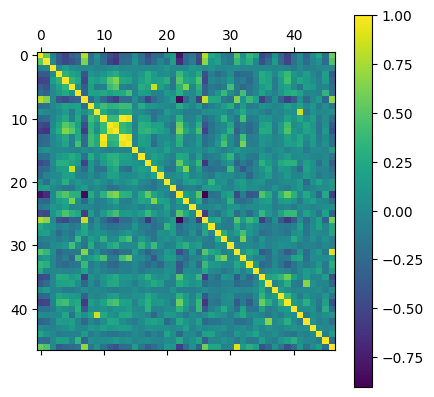

Fertility rate, total (births per woman) [SP.DYN.TFRT.IN]
GNI per capita, PPP (current international $) [NY.GNP.PCAP.PP.CD]
GNI, Atlas method (current US$) [NY.GNP.ATLS.CD]
GNI, PPP (current international $) [NY.GNP.MKTP.PP.CD]
Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS]
Life expectancy at birth, total (years) [SP.DYN.LE00.IN]
Mortality rate, under-5 (per 1,000 live births) [SH.DYN.MORT]
Surface area (sq. km) [AG.SRF.TOTL.K2]
Urban population growth (annual %) [SP.URB.GROW]
38


In [25]:
#Pearson Coefficent
corr_matrix = X_train_norm.corr(method='pearson')
plt.matshow(corr_matrix)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.show()

corr_matrix = corr_matrix.abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
for attr in to_drop:
  print(attr)
print(len(X_train_norm.columns)-len(to_drop))

Chi-Squared

In [26]:
#Chi-Squared
# X_norm = MinMaxScaler().fit_transform(X_train)
chi_selector = SelectKBest(chi2, k=30)
chi_selector.fit(X_train_norm, y_train)
chi_support = chi_selector.get_support()
chi_feature = X_train_norm.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
for f in chi_feature:
  print(f)
to_drop = []
for attr in X_train_norm.columns:
  if attr not in chi_feature and attr != "GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]":
    to_drop.append(attr)
print(len(X_train_norm.columns)-len(to_drop))

30 selected features
Adolescent fertility rate (births per 1,000 women ages 15-19) [SP.ADO.TFRT]
Agriculture, forestry, and fishing, value added (% of GDP) [NV.AGR.TOTL.ZS]
Annual freshwater withdrawals, total (% of internal resources) [ER.H2O.FWTL.ZS]
Births attended by skilled health staff (% of total) [SH.STA.BRTC.ZS]
CO2 emissions (metric tons per capita) [EN.ATM.CO2E.PC]
External debt stocks, total (DOD, current US$) [DT.DOD.DECT.CD]
Fertility rate, total (births per woman) [SP.DYN.TFRT.IN]
Forest area (sq. km) [AG.LND.FRST.K2]
GDP (current US$) [NY.GDP.MKTP.CD]
GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]
GNI per capita, PPP (current international $) [NY.GNP.PCAP.PP.CD]
GNI, Atlas method (current US$) [NY.GNP.ATLS.CD]
Gross capital formation (% of GDP) [NE.GDI.TOTL.ZS]
Immunization, measles (% of children ages 12-23 months) [SH.IMM.MEAS]
Inflation, GDP deflator (annual %) [NY.GDP.DEFL.KD.ZG]
Life expectancy at birth, total (years) [SP.DYN.LE00.IN]
Military expendit

Information gain

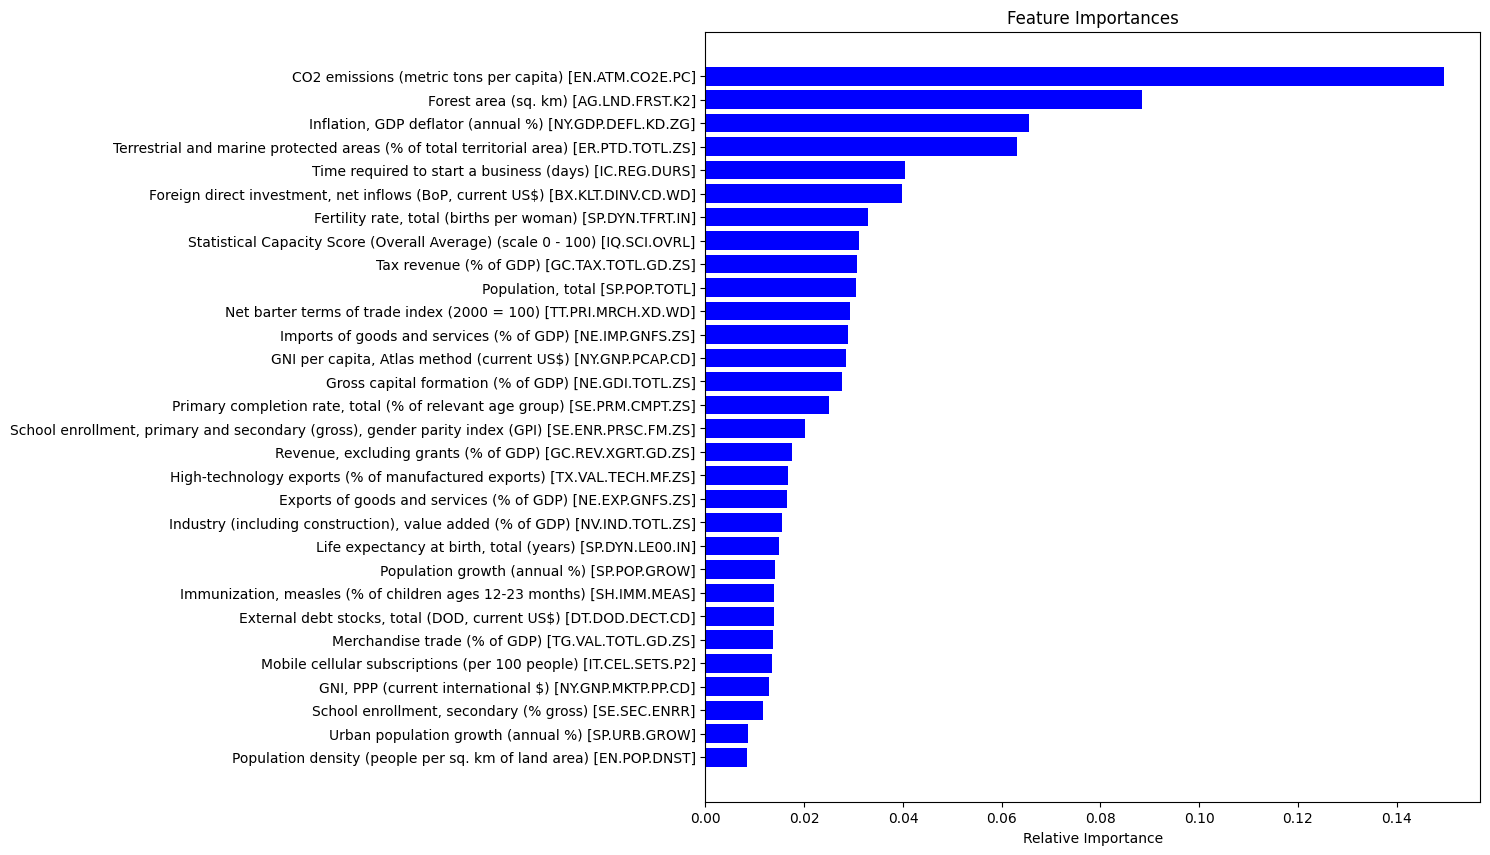

30


In [27]:
#Info gain decision tree model
model = DecisionTreeClassifier(criterion='entropy')
X_dummies = pd.get_dummies(X_train_norm)
model.fit(X_dummies, y_train)
features = X_dummies.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-30:]  # top 30 features
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
relevant = [features[i] for i in indices]
to_drop = []
for attr in X_train_norm.columns:
  if attr not in relevant and attr != "GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]":
    to_drop.append(attr)
print(len(X_train_norm.columns)-len(to_drop))

Random Forest

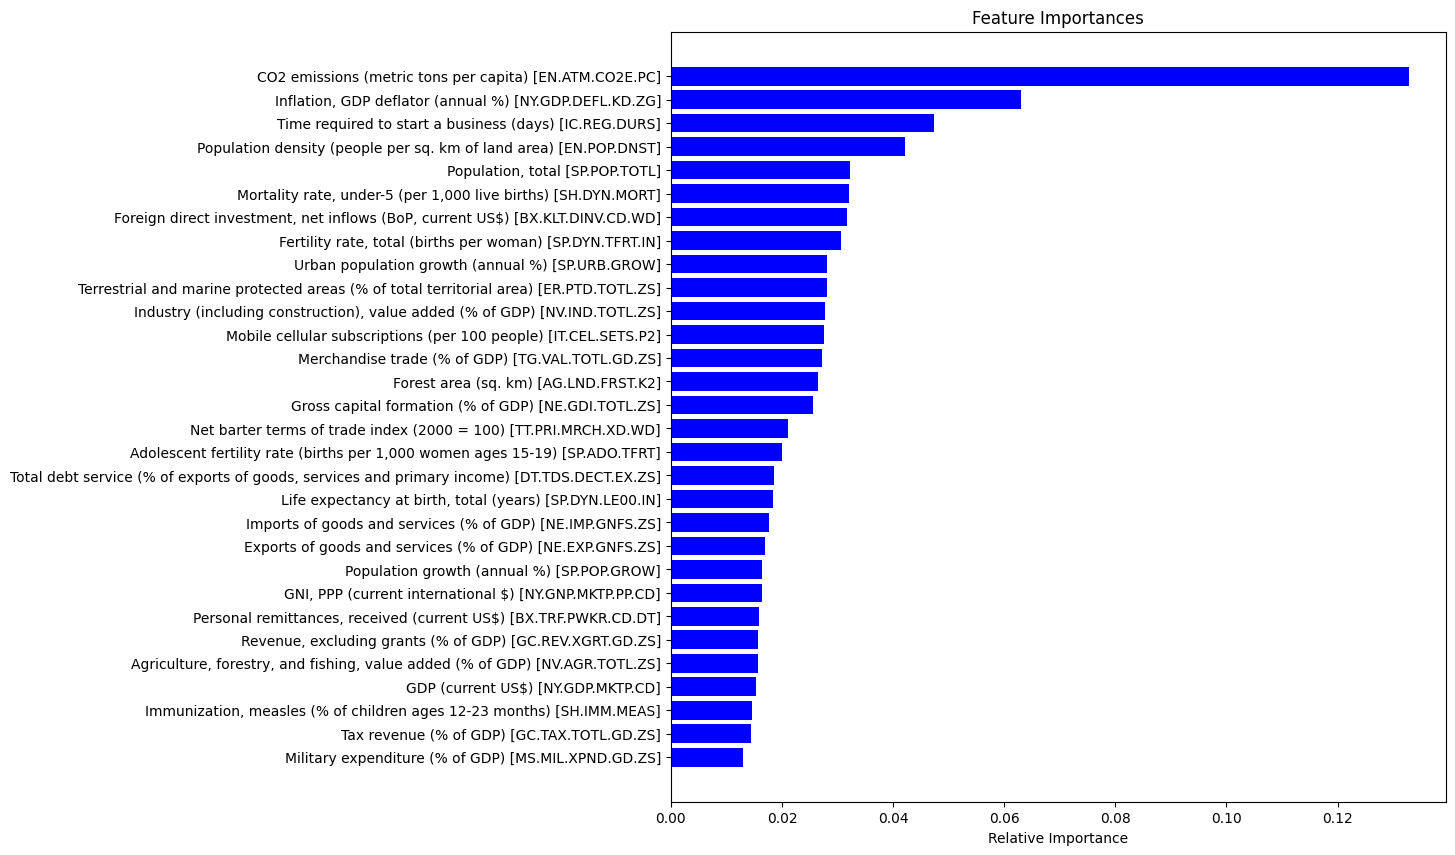

30


In [35]:
#Random Forest Regressor for dimensionality reduction
model = RandomForestRegressor(random_state=1, max_depth=10)
X_dummies = pd.get_dummies(X_train_norm)
model.fit(X_dummies, y_train.values.ravel())
features = X_dummies.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-30:]  # top 30 features
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
to_drop = []
relevant = [features[i] for i in indices]
for attr in X_train_norm.columns:
  if attr not in relevant and attr != "GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]":
    to_drop.append(attr)
print(len(X_train_norm.columns)-len(to_drop))

Intuition

In [29]:
keep_list = ["CO2 emissions (metric tons per capita) [EN.ATM.CO2E.PC]",
              'Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]',
              'Forest area (sq. km) [AG.LND.FRST.K2]',
              'Population growth (annual %) [SP.POP.GROW]',
              'Surface area (sq. km) [AG.SRF.TOTL.K2]',
       'High-technology exports (% of manufactured exports) [TX.VAL.TECH.MF.ZS]',
       'Income share held by lowest 20% [SI.DST.FRST.20]',
       'Life expectancy at birth, total (years) [SP.DYN.LE00.IN]',
       'Urban population growth (annual %) [SP.URB.GROW]',
       'Foreign direct investment, net inflows (BoP, current US$) [BX.KLT.DINV.CD.WD]',
       'Inflation, GDP deflator (annual %) [NY.GDP.DEFL.KD.ZG]']
to_drop = []
for attr in X_train_norm.columns:
  if attr not in keep_list and attr != "GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]":
    to_drop.append(attr)
print(str(len(X_train_norm.columns)-len(to_drop)), "selected features")
for a in keep_list:
  print(a)

11 selected features
CO2 emissions (metric tons per capita) [EN.ATM.CO2E.PC]
Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]
Forest area (sq. km) [AG.LND.FRST.K2]
Population growth (annual %) [SP.POP.GROW]
Surface area (sq. km) [AG.SRF.TOTL.K2]
High-technology exports (% of manufactured exports) [TX.VAL.TECH.MF.ZS]
Income share held by lowest 20% [SI.DST.FRST.20]
Life expectancy at birth, total (years) [SP.DYN.LE00.IN]
Urban population growth (annual %) [SP.URB.GROW]
Foreign direct investment, net inflows (BoP, current US$) [BX.KLT.DINV.CD.WD]
Inflation, GDP deflator (annual %) [NY.GDP.DEFL.KD.ZG]


Feature Reduction

In [36]:
X_train_fr = X_train_norm.drop(to_drop, axis=1, inplace=False)
X_test_fr = X_test_norm.drop(to_drop, axis=1, inplace=False)
print(len(X_train_fr.columns))
print(len(X_test_fr.columns))

30
30


Classification Algorithms
1. Naive bayes
2. Decision tree
3. Support Vector Machine (SVM)
4. MLP Classifier

Naive Bayes

[[ 30  44]
 [ 60 231]]
accuracy: 0.7150684931506849
f1 score: 0.8162544169611307


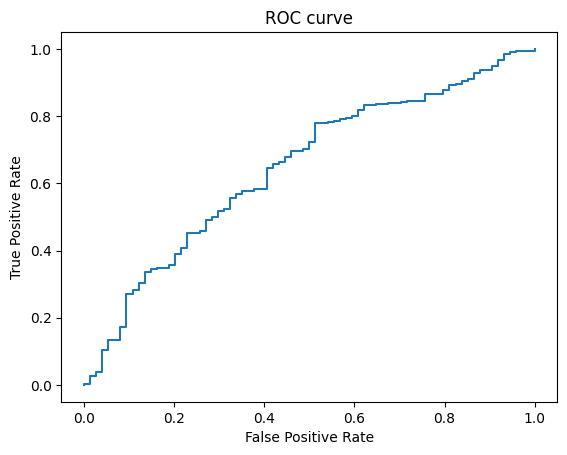

auc: 0.6455837280579548


In [37]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train_fr, y_train.values.ravel()).predict(X_test_fr)
cm = confusion_matrix(y_test, y_pred)
print(cm)
acc_mlp = accuracy_score(y_test, y_pred)
print ('accuracy:', acc_mlp)
print('f1 score:', metrics.f1_score(y_test, y_pred))

#roc/auc
y_score = gnb.fit(X_train_fr, y_train.values.ravel()).predict_proba(X_test_fr)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')
plt.show()
print('auc:', metrics.auc(fpr, tpr))

Decision Tree

[[ 47  27]
 [ 37 254]]
accuracy: 0.8246575342465754
f1 score: 0.8881118881118881


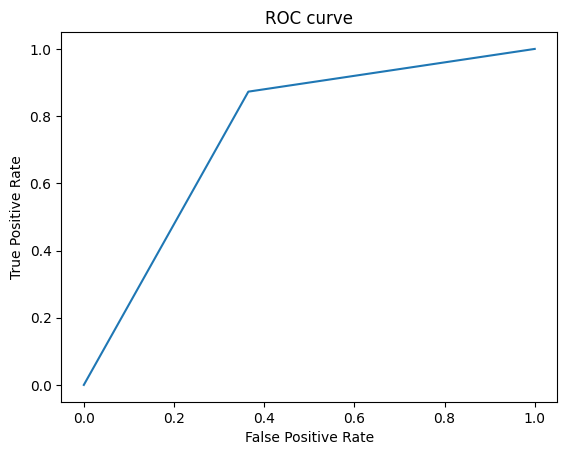

auc: 0.7539936844060555


In [38]:
clf = DecisionTreeClassifier(random_state = 0)
clf = clf.fit(X_train_fr,y_train)
y_pred = clf.predict(X_test_fr)
cm = confusion_matrix(y_test, y_pred)
print(cm)
acc_mlp = accuracy_score(y_test, y_pred)
print ('accuracy:', acc_mlp)
print('f1 score:', metrics.f1_score(y_test, y_pred))

#roc/auc
y_score = clf.fit(X_train_fr, y_train).predict_proba(X_test_fr)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')
plt.show()
print('auc:', metrics.auc(fpr, tpr))

Support Vector Machine (SVM)

[[ 27  47]
 [ 29 262]]
accuracy: 0.7917808219178082
f1 score: 0.8733333333333333


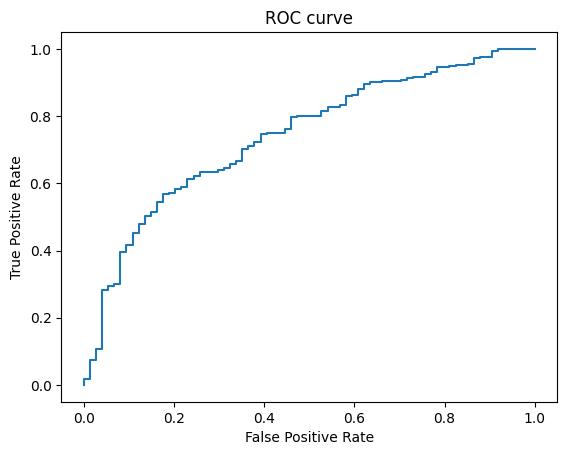

auc: 0.7399461316987089


In [39]:
clf = svm.SVC(kernel = 'rbf', random_state = 0, C=100, gamma=10)
clf.fit(X_train_fr, y_train.values.ravel())
y_pred = clf.predict(X_test_fr)
cm = confusion_matrix(y_test, y_pred)
print(cm)
acc_mlp = accuracy_score(y_test, y_pred)
print ('accuracy:', acc_mlp)
print('f1 score:', metrics.f1_score(y_test, y_pred))
y_score = clf.fit(X_train_fr, y_train.values.ravel()).decision_function(X_test_fr)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_score)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')
plt.show()
print('auc:', metrics.auc(fpr, tpr))

MLP Classifier

[[ 29  45]
 [ 16 275]]
accuracy: 0.8328767123287671
f1 score: 0.9001636661211129


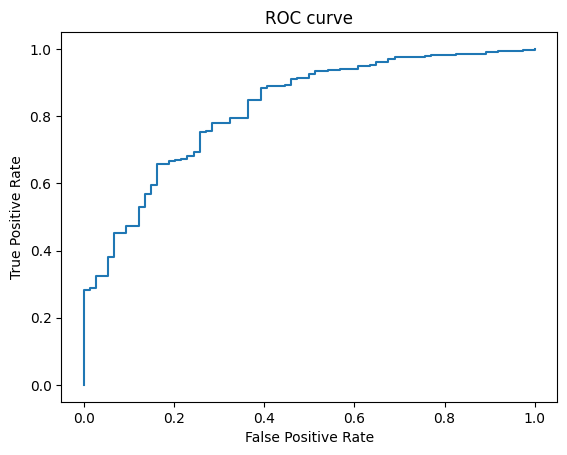

auc: 0.8224203585028327


In [40]:
from sklearn.neural_network import MLPClassifier
# mlp = MLPClassifier(alpha=1, max_iter=1000, random_state = 5)
# hidden_layer_sizes=(150,100,50),
mlp = MLPClassifier(max_iter=1000, activation = 'relu', solver='adam', random_state=0)
mlp.fit(X_train_fr, y_train.values.ravel())
y_pred_mlp = mlp.predict(X_test_fr)
cm = confusion_matrix(y_test, y_pred_mlp)
print(cm)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
print ('accuracy:', acc_mlp)
print('f1 score:', metrics.f1_score(y_test, y_pred_mlp))

#roc/auc
y_score = mlp.fit(X_train_fr, y_train.values.ravel()).predict_proba(X_test_fr)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')
plt.show()
print('auc:', metrics.auc(fpr, tpr))